# Decision Tree Experiment

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


# Constants

In [254]:
NA_DROP_THRESHOLD = 0.5
CORRELATION_FILTER_THRESHOLD=0.8
KFOLD_N_SPLITS = 3
RANDOM_STATE=42
DECISION_TREE_INITIAL_MAX_DEPTH=5

# Load Data

In [226]:
# Load each data table
transactions = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
identities = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

# Merge data tables
df = pd.merge(transactions, identities, on="TransactionID")

# Free up memory
del transactions
del identities

In [155]:
from sklearn.model_selection import train_test_split

# Take small sample from the whole dataset for testing my code quickly
X_sample = df[:100].copy()

y_sample = X_sample["isFraud"]
X_sample.drop(columns=["isFraud"], inplace=True)

In [129]:
X_sample.shape, y_sample.shape

((1000, 433), (1000,))

In [130]:
y_sample.value_counts(normalize=True)

isFraud
0    0.951
1    0.049
Name: proportion, dtype: float64

In [8]:
# Separate features and target values
y = df["isFraud"]
X = df.drop(columns=["isFraud"])

In [11]:
X.shape, y.shape

((144233, 433), (144233,))

In [10]:
# The data is extremely imbalanced
y.value_counts(normalize=True)

isFraud
0    0.92153
1    0.07847
Name: proportion, dtype: float64

# Cleaning

### Drop values with high NA content

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNAFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self._feats_to_drop = []
        self.threshold = threshold
    
    def fit(self, X, y=None):
        
        na_dist = X.isna().mean()
        for feat, na_ratio in na_dist.items():
            if na_ratio > self.threshold:
                self._feats_to_drop.append(feat)
        
        return self

    def transform(self, X):
        X = X.copy()

        # Drop features with high NA content
        X.drop(columns=self._feats_to_drop, inplace=True)

        return X

### Fill NA values

In [101]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillNAWithMedian(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._na_mapping = {}
    
    def fit(self, X, y=None):
        
        for feat in X.columns:
            median = X[feat].median()
            self._na_mapping[feat] = median
        
        return self

    def transform(self, X):
        X = X.copy()

        for feat, value in self._na_mapping.items():
            X[feat] = X[feat].fillna(value)
        
        return X

### Log Pipeline with Cleaning Steps

In [252]:
partial_pipeline = Pipeline([
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
])
log_model(
    run_name="DecisionTree_Cleaning", 
    params={
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    },
    metrics={},
    best_pipeline=partial_pipeline
)

2025/04/27 06:24:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 06:24:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_Cleaning at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/11d1ac5e32344e4ab1833a90e8bb8058
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


# Feature Engineering

### Encode Categories Using WOE

In [99]:
import category_encoders

# Find every categorical feature in the data
cat_feats = [feat for feat in X.columns if X[feat].dtype == "object"]

# Create woe encoder for the features
woe_encoder = category_encoders.WOEEncoder(cols=cat_feats)

In [253]:
partial_pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
])
log_model(
    run_name="DecisionTree_FeatureEngineering", 
    params={
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    },
    metrics={},
    best_pipeline=partial_pipeline
)

2025/04/27 06:27:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 06:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_FeatureEngineering at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/7236f8adc76c430fb86da03c243a2d55
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


# Feature Selection

### Correlation Filter

In [227]:
from sklearn.base import BaseEstimator, TransformerMixin

# Disclaimer: Part of the following Correlation Filter code is borrowed from Seminar 7 Kaggle notebook
# I modified the code to be used as a pipeline

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self._feats_to_drop = []
        self.threshold = threshold
    
    def fit(self, X, y):
        corr_features = self._find_correlated_features(X, y)
        
        for feats in corr_features:
            if(X[feats[0]].corr(y) < X[feats[1]].corr(y)):
                self._feats_to_drop.append(feats[0])
            else:
                self._feats_to_drop.append(feats[1])

        return self

    def transform(self, X):
        X = X.copy()

        X.drop(columns=self._feats_to_drop, inplace=True)
        
        return X

    def _find_correlated_features(self, X, y):
        result = []
        corr_matrix = X.corr().abs()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    result.append((corr_matrix.columns[i], corr_matrix.columns[j]))

        return result

### RFE

In [255]:
classifier = DecisionTreeClassifier(max_depth=DECISION_TREE_INITIAL_MAX_DEPTH, random_state=RANDOM_STATE)
rfe = RFE(estimator=classifier, step=1)

In [257]:
partial_pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('correlation_filter', CorrelationFilter(threshold=CORRELATION_FILTER_THRESHOLD)),
    ('feature_selector', rfe),
])
log_model(
    run_name="DecisionTree_FeatureSelection", 
    params={
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "correlation_filter_threshold": CORRELATION_FILTER_THRESHOLD,
    "classifier_max_depth": DECISION_TREE_INITIAL_MAX_DEPTH,
    },
    metrics={},
    best_pipeline=partial_pipeline
)

2025/04/27 06:32:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_FeatureSelection at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/de290abbde83422aa5f8be8ccfb74ad6
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


# Final Pipeline

In [151]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

def create_pipeline():
    model = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
    pipeline = Pipeline([
        ('woe_encoder', woe_encoder),
        ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
        ('fill_na_with_median', FillNAWithMedian()),
        ('correlation_filter', CorrelationFilter(threshold=CORRELATION_FILTER_THRESHOLD)),
        ('scaler', StandardScaler()),
        ('feature_selector', RFE(estimator=model, step=1)),
        ('classifier', model),
    ])
    return pipeline

# Training

In [247]:
# Specify parameters to try using GridSearch
param_grid = {
    "feature_selector__n_features_to_select": [5, 10, 20],
    "classifier__max_depth": [5, 10],
}

In [248]:
from sklearn.model_selection import GridSearchCV

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
pipeline = create_pipeline()
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [249]:
grid_search.fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END classifier__max_depth=5, feature_selector__n_features_to_select=5;, score=(train=0.821, test=0.820) total time= 1.8min
[CV 2/3] END classifier__max_depth=5, feature_selector__n_features_to_select=5;, score=(train=0.828, test=0.821) total time= 1.6min
[CV 3/3] END classifier__max_depth=5, feature_selector__n_features_to_select=5;, score=(train=0.824, test=0.820) total time= 1.7min
[CV 1/3] END classifier__max_depth=5, feature_selector__n_features_to_select=10;, score=(train=0.799, test=0.797) total time= 1.8min
[CV 2/3] END classifier__max_depth=5, feature_selector__n_features_to_select=10;, score=(train=0.798, test=0.792) total time= 1.5min
[CV 3/3] END classifier__max_depth=5, feature_selector__n_features_to_select=10;, score=(train=0.806, test=0.801) total time= 1.7min
[CV 1/3] END classifier__max_depth=5, feature_selector__n_features_to_select=20;, score=(train=0.799, test=0.797) total time= 1.7min
[CV 2/3] END

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                        CorrelationFilter(threshold=0.8)),
                                       ('scaler', StandardScaler()),
                                       ('feature_selector',
                                        RFE(estimator=DecisionTreeClassifier(max_depth=5,
                                                                             random_state=42))),
                                       ('classifier',
                                        DecisionTreeClassifier(max_depth=5,
                                                               random_state=42))]),
             param_grid={'classifier__max_depth': [5, 10],
                         'feature_selector__n_features_to_select': [5, 10, 20]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [279]:
grid_search.best_score_

0.8642967179379735

In [259]:
grid_search.best_params_

{'classifier__max_depth': 10, 'feature_selector__n_features_to_select': 10}

# Graph ROC Curve

In [280]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X, y):
    
    # Predict probabilities
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    
    plt.title("ROC Curve on Training Set")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(fpr, tpr, color="blue")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"decision_tree_roc_curve.png")
    plt.show()

    # Draw Mirrored ROC curve
    tnr = 1 - fpr
    plt.figure(figsize=(10, 8))
    
    plt.title("Mirrored ROC Curve on Training Set")
    plt.xlabel('True Negative Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(tnr, tpr, color="red")
    plt.plot([0, 1], [1, 0], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"decision_tree_roc_curve_mirrored.png")
    plt.show()

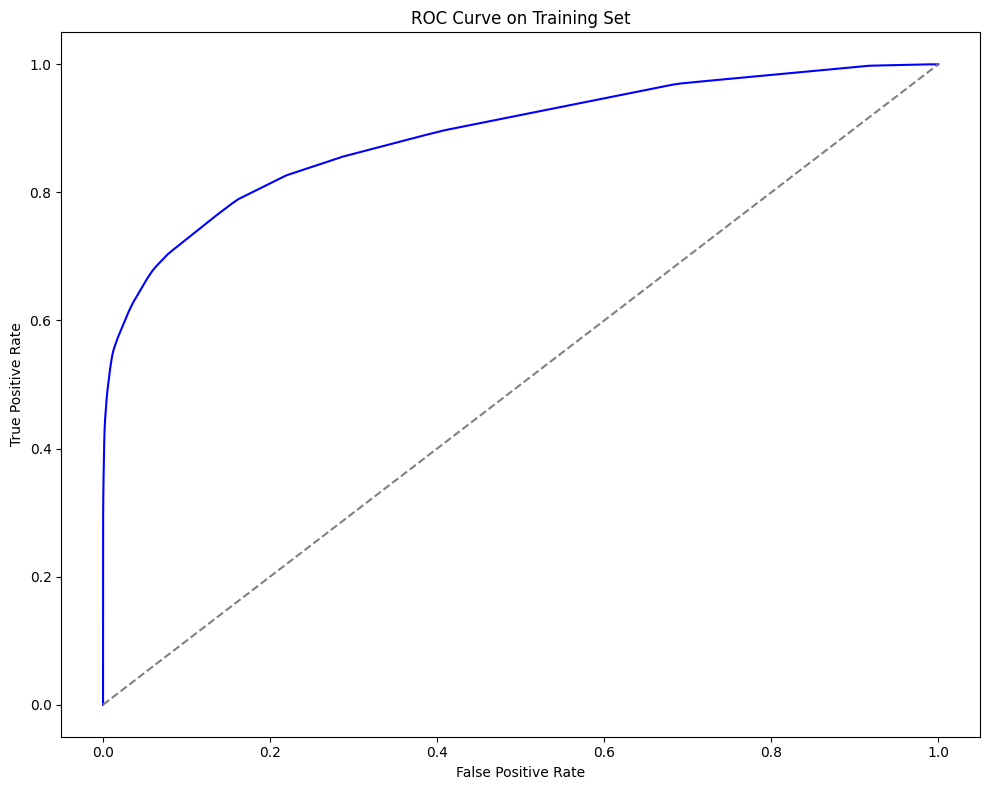

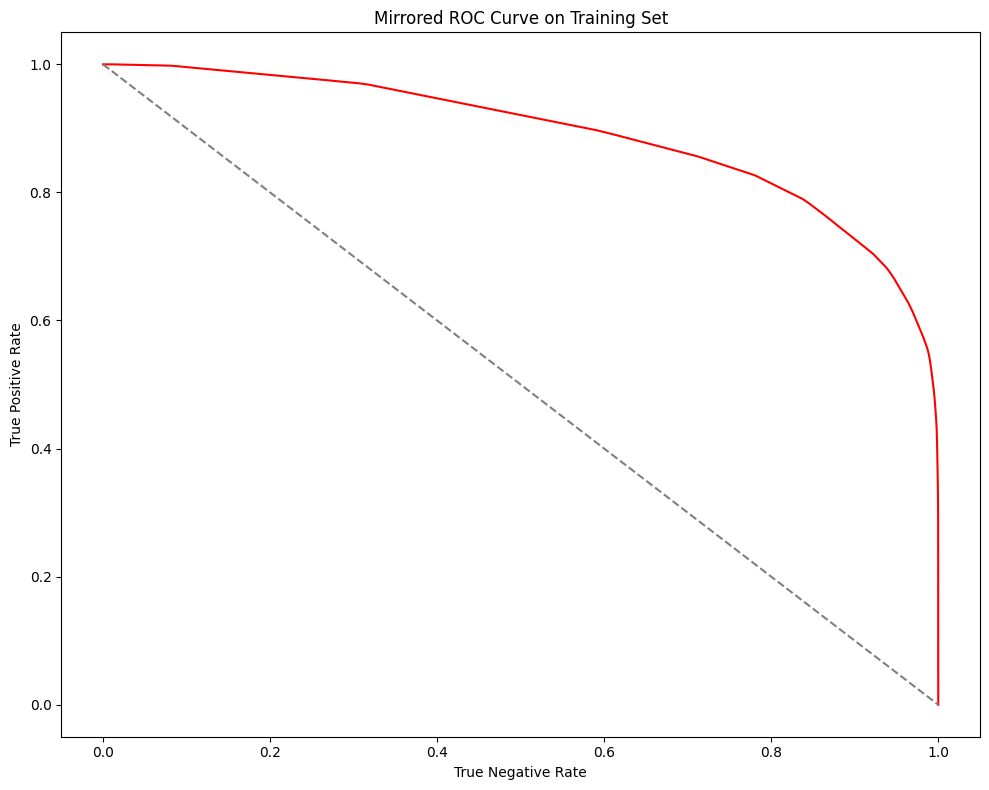

In [281]:
best_pipeline = grid_search.best_estimator_
plot_roc(best_pipeline, X, y)

# Log Experiments

In [ ]:
!pip install mlflow dagshub

In [97]:
import dagshub
dagshub.auth.add_app_token('ed22b8f88bed7c968c7425f62448b33703f4e094')
dagshub.init(repo_owner='vvaza22', repo_name='ml-assignment-2', mlflow=True)

Accessing as vvaza22

Initialized MLflow to track repo "vvaza22/ml-assignment-2"

Repository vvaza22/ml-assignment-2 initialized!

In [274]:
import mlflow

def log_model(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("DecisionTree_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(best_pipeline, "DecisionTree")
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

In [260]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "correlation_filter_threshold": CORRELATION_FILTER_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}

In [261]:
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'correlation_filter_threshold': 0.8,
 'kfold_n_splits': 3,
 'classifier__max_depth': 10,
 'feature_selector__n_features_to_select': 10}

In [262]:
def get_metrics(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the best result from the grid search
    best_result = results.sort_values(by="rank_test_score").iloc[0].to_dict()

    # Remove parameter values
    keys_to_drop = []
    for key in best_result.keys():
        if key.startswith("param"):
            keys_to_drop.append(key)
    
    for key in keys_to_drop:
        del best_result[key]

    del best_result["rank_test_score"]

    return best_result

In [263]:
metrics = get_metrics(grid_search)

In [264]:
metrics

{'mean_fit_time': 99.01520665486653,
 'std_fit_time': 6.53615796850858,
 'mean_score_time': 1.2209939161936443,
 'std_score_time': 0.018037736310018888,
 'split0_test_score': 0.8720992650486488,
 'split1_test_score': 0.8608212959387218,
 'split2_test_score': 0.8599695928265496,
 'mean_test_score': 0.8642967179379735,
 'std_test_score': 0.00552817966474513,
 'split0_train_score': 0.8920870884986138,
 'split1_train_score': 0.8827594078907665,
 'split2_train_score': 0.8854989289929489,
 'mean_train_score': 0.8867818084607765,
 'std_train_score': 0.0039145660617096135}

In [265]:
best_pipeline = grid_search.best_estimator_

In [278]:
log_model(
    run_name="DecisionTree_Model",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["decision_tree_roc_curve.png", "decision_tree_roc_curve_mirrored.png"]
)

2025/04/27 06:47:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_Model at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/4766c0aa7ea14598b518b5b4d43ee025
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0
